In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
matplotlib.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['figure.constrained_layout.use'] = True


# feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression # F-value between label/feature for regression tasks.

# model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle


from final.random_sampling.even_sample_brand import stratified_sampling_by_brand
from final.random_sampling.even_sample_category import stratified_sampling_by_category
from final.random_sampling.even_sample_by_price_range import stratified_sampling_by_price
from final.feature_extraction.text_vectorization import encode_categories,encode_string_column

from final.hyperparameter_tuning.search_cv import CV_Model


from final.model_evaluation.error_function import mape
from final.model_evaluation.visualizations import plot_prediction_price
from final.model_evaluation.regression_cvs import find_train_best_model

# Get sample df

In [2]:
df = pd.read_csv("data/clean_data_with_text_features.csv")
df = stratified_sampling_by_brand(df, file_dir="data",number_samples = 10000,
                                               replace = False, save_sample_df = False)

boohoo                      6
clarins                     6
mega bloks                  6
michi by michelle watson    6
lord taylor                 6
                           ..
colourpop cosmetics         5
moschino                    5
energizer                   5
bill blass                  5
christian siriano           4
Name: brand_name, Length: 1678, dtype: int64


In [3]:
df.shape

(10000, 46)

In [4]:
df.head(5)

,,train_id,item_condition_id,brand_name,price,shipping,c1,c2,c3,clean_name,clean_description,...,brand_nameLength,brand_nameLowerCount,brand_nameLowerRatio,brand_nameAvgWordLen,nameStopWordCount,namePunctuationCount,nameSpecialCount,item_descriptionStopWordCount,item_descriptionPunctuationCount,item_descriptionSpecialCount
brand_name,,,,,,,,,,,,,,,,,,,,,,
john deere,1399304,1400676,1,john deere,8.0,0,men,men s accessories,hat,toddler john deere hat,never worn toddler hat,...,0.243243,0.264706,0.900000,0.285714,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
emerson,430179,430551,1,emerson,220.0,1,electronics,computers tablets,networking connectivity,avocent server kvm switch 16 ports,avocent autoview av3216 kvm switch 16 ports ra...,...,0.162162,0.205882,1.000000,0.428571,0.0,0.068966,0.105263,0.131148,0.028736,0.014201
boys arrows,658820,659438,2,boys arrows,19.0,0,woman,swimwear,two piece,printed bikini,size medium just too big for me padded not boy...,...,0.270270,0.294118,0.909091,0.321429,0.0,0.000000,0.000000,0.155738,0.011494,0.005917
pets first,1245532,1246735,4,pets first,6.0,1,other,pet supplies,dog,dog yankees jersey,this is probably and xs yankees jersey please ...,...,0.243243,0.264706,0.900000,0.285714,0.0,0.000000,0.000000,0.065574,0.005747,0.002367
covington,1479307,1480759,3,covington,7.0,1,woman,athletic apparel,shirts tops,covington ladies top size xl vguc,this is a ladies covington top that is a size ...,...,0.216216,0.264706,1.000000,0.571429,0.0,0.000000,0.000000,0.122951,0.003831,0.001183


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, ('john deere', 1399304) to ('charlie banana', 1257188)
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   train_id                          10000 non-null  int64  
 1   item_condition_id                 10000 non-null  int64  
 2   brand_name                        10000 non-null  object 
 3   price                             10000 non-null  float64
 4   shipping                          10000 non-null  int64  
 5   c1                                10000 non-null  object 
 6   c2                                10000 non-null  object 
 7   c3                                10000 non-null  object 
 8   clean_name                        10000 non-null  object 
 9   clean_description                 10000 non-null  object 
 10  clean_nameWordCount               10000 non-null  float64
 11  clean_nameLength       

# Train Test Split

In [6]:
Y = np.log1p(df['price'])
df.drop(['price'], axis=1, inplace=True)
df.head(2)

,,train_id,item_condition_id,brand_name,shipping,c1,c2,c3,clean_name,clean_description,clean_nameWordCount,...,brand_nameLength,brand_nameLowerCount,brand_nameLowerRatio,brand_nameAvgWordLen,nameStopWordCount,namePunctuationCount,nameSpecialCount,item_descriptionStopWordCount,item_descriptionPunctuationCount,item_descriptionSpecialCount
brand_name,,,,,,,,,,,,,,,,,,,,,,
john deere,1399304,1400676,1,john deere,0,men,men s accessories,hat,toddler john deere hat,never worn toddler hat,0.1875,...,0.243243,0.264706,0.9,0.285714,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
emerson,430179,430551,1,emerson,1,electronics,computers tablets,networking connectivity,avocent server kvm switch 16 ports,avocent autoview av3216 kvm switch 16 ports ra...,0.3125,...,0.162162,0.205882,1.0,0.428571,0.0,0.068966,0.105263,0.131148,0.028736,0.014201


In [7]:
train_df, test_df , y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=12342)
print('Train size: %s, Test size: %s'%(train_df.shape, test_df.shape))

Train size: (8000, 45), Test size: (2000, 45)


# Vectorization

In [8]:
train_cat_features, test_cat_features, train_cat_features_name = encode_categories(train_df, test_df,
                                                                columns = ['c1','c2','c3','brand_name'], 
                                                                min_df = 10, print_progress=True)

Size of vectorization features of c1 is 12
Size of vectorization features of c2 is 100
Size of vectorization features of c3 is 269
Size of vectorization features of brand_name is 215
Shape of train vectorization features of ['c1', 'c2', 'c3', 'brand_name'] is (8000, 596)
Shape of test vectorization features of ['c1', 'c2', 'c3', 'brand_name'] is (2000, 596)


In [9]:
train_str_features, test_str_features, train_str_features_name = encode_string_column(train_df, test_df,
                                                                   columns=['clean_name', 'clean_description'],
                                                                   min_df=10, max_features=15000, 
                                                                   print_progress=True)

Size of vectorization features of clean_name is 649
Size of vectorization features of clean_description is 4041
Shape of train vectorization features of ['clean_name', 'clean_description'] is (8000, 4690)
Shape of test vectorization features of ['clean_name', 'clean_description'] is (2000, 4690)


# Combine all features

In [10]:
other_columns = list(train_df.select_dtypes([np.number]).columns)
other_columns.remove('train_id')
other_columns

['item_condition_id',
 'shipping',
 'clean_nameWordCount',
 'clean_nameLength',
 'clean_nameLowerCount',
 'clean_nameLowerRatio',
 'clean_nameAvgWordLen',
 'clean_descriptionWordCount',
 'clean_descriptionLength',
 'clean_descriptionLowerCount',
 'clean_descriptionLowerRatio',
 'clean_descriptionAvgWordLen',
 'c1WordCount',
 'c1Length',
 'c1LowerCount',
 'c1LowerRatio',
 'c1AvgWordLen',
 'c2WordCount',
 'c2Length',
 'c2LowerCount',
 'c2LowerRatio',
 'c2AvgWordLen',
 'c3WordCount',
 'c3Length',
 'c3LowerCount',
 'c3LowerRatio',
 'c3AvgWordLen',
 'brand_nameWordCount',
 'brand_nameLength',
 'brand_nameLowerCount',
 'brand_nameLowerRatio',
 'brand_nameAvgWordLen',
 'nameStopWordCount',
 'namePunctuationCount',
 'nameSpecialCount',
 'item_descriptionStopWordCount',
 'item_descriptionPunctuationCount',
 'item_descriptionSpecialCount']

In [11]:
train_other_features = train_df[other_columns].values
test_other_features = test_df[other_columns].values
print('Train other features size: %s, Test other features size: %s'%(train_other_features.shape, 
                                                                     test_other_features.shape))

Train other features size: (8000, 38), Test other features size: (2000, 38)


In [12]:
all_train = np.hstack((train_cat_features, train_str_features, train_other_features))
all_test = np.hstack((test_cat_features, test_str_features, test_other_features))
print('Train features size: %s, Test features size: %s'%(all_train.shape, 
                                                         all_test.shape))

Train features size: (8000, 5324), Test features size: (2000, 5324)


# Feature Selection

# Select K Best

In [13]:
skb = SelectKBest(f_regression, k=500)
x_skb_select_train = skb.fit_transform(all_train, y_train)
x_skb_select_test = skb.transform(all_test)

In [14]:
x_skb_select_train.shape

(8000, 500)

In [15]:
x_skb_select_test.shape

(2000, 500)

# Hyperparameter Tuning

In [16]:
SearchCV = CV_Model(GridSearch=False)

## KNN

In [17]:
classifier = KNeighborsRegressor()
parameters = {'n_neighbors': [5, 10, 50, 100], 'weights': ['uniform', 'distance']}

### Train with select k best features

In [18]:
x_skb_select_train.shape

(8000, 500)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Estimator KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')
Best Parameters:  {'weights': 'distance', 'n_neighbors': 10}
Best Score:  -0.4576851255801992
Result of using Feature from select k best model
--------------------------------------------------
For price under $30
Train Result ----------
Max Percentage Difference:  0.08021953923267092
With Original Price 30.00, Predict Price 32.41: 
Min Percentage Difference:  0.0
With Original Price 25.00, Predict Price 25.00: 
RMSLE is  0.0014544070630320867
R^2  is  0.9999887309648384
Mean Absolute Percentage Error is  0.004313812304661074

Test Result ----------
Max Percentage Difference:  13.447839986932758
With Original Price 6.00, Predict Price 86.69: 
Min Percentage Difference:  3.5946149773568484e-05
With Original Price 17.00, Predict Price 17.00: 
RMSLE is  0.4934354065888562
R^2 is  -0.51295074

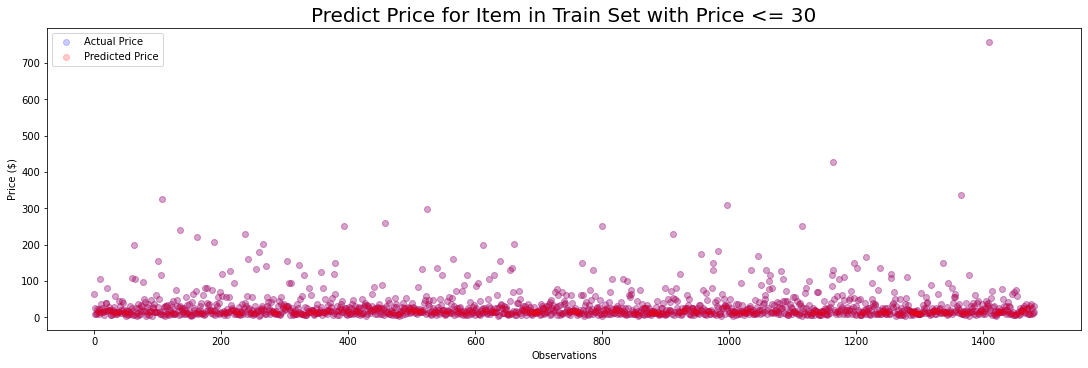

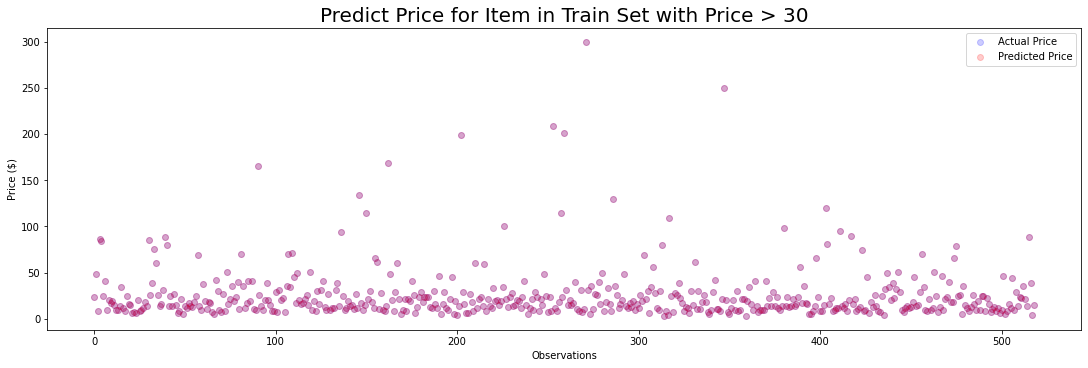

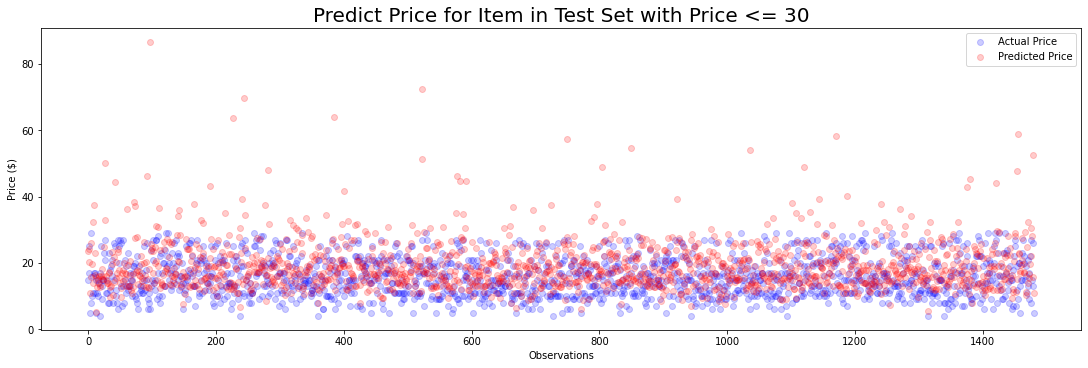

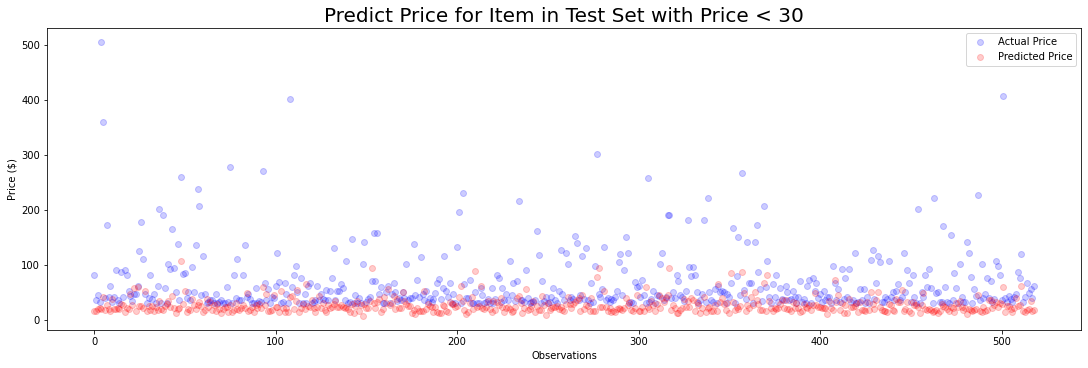

In [19]:
find_train_best_model(classifier, parameters, x_skb_select_train, y_train, 
                      x_skb_select_test, y_test, data_name="Feature from select k best model", price_split=30)

### Train with All features

In [22]:
all_train.shape

(8000, 5324)

In [23]:
classifier = KNeighborsRegressor()
parameters = {'n_neighbors': [5, 10, 50, 100], 'weights': ['uniform', 'distance']}

In [ ]:
find_train_best_model(classifier, parameters, all_train, y_train, 
                      all_test, y_test, data_name="Feature from all data", price_split=30)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


## Ridge

### Train with select k best features

In [20]:
classifier = Ridge()
parameters = {'alpha': [1, 2, 3, 3.5, 4, 4.5, 5]}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Estimator Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
Best Parameters:  {'alpha': 1}
Best Score:  -0.37483437688865834
Result of using Feature from select k best model
--------------------------------------------------
For price under $30
Train Result ----------
Max Percentage Difference:  11.516272940639354
With Original Price 3.00, Predict Price 37.55: 
Min Percentage Difference:  2.2582929293690768e-05
With Original Price 12.00, Predict Price 12.00: 
RMSLE is  0.4618246284799187
R^2  is  -0.13623709359829017
Mean Absolute Percentage Error is  52.254488558142455

Test Result ----------
Max Percentage Difference:  9.150453649763984
With Original Price 7.00, Predict Price 71.05: 
Min Percentage Difference:  0.0004382308645539679
With Original Price 16.00, Predict Price 16.01: 
RMSLE is  0.49023205722552815
R^2 is  -0.4933705571985889
Mean Absolute Percentage Error is  51.848042093267544
--------

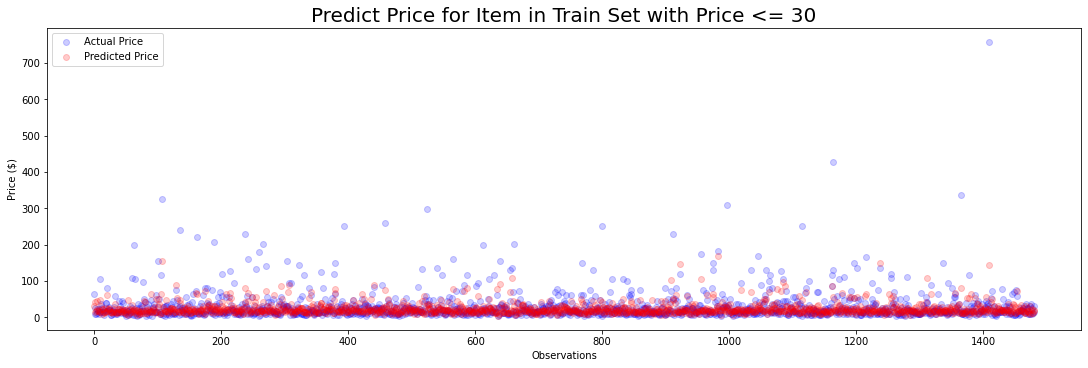

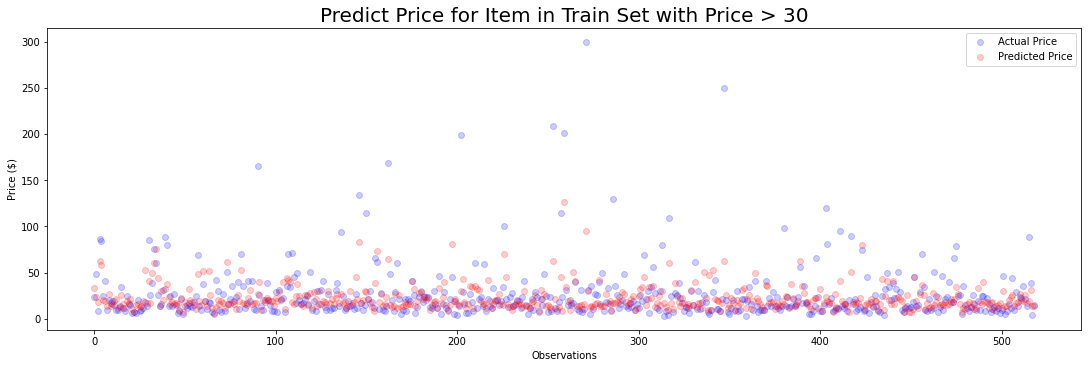

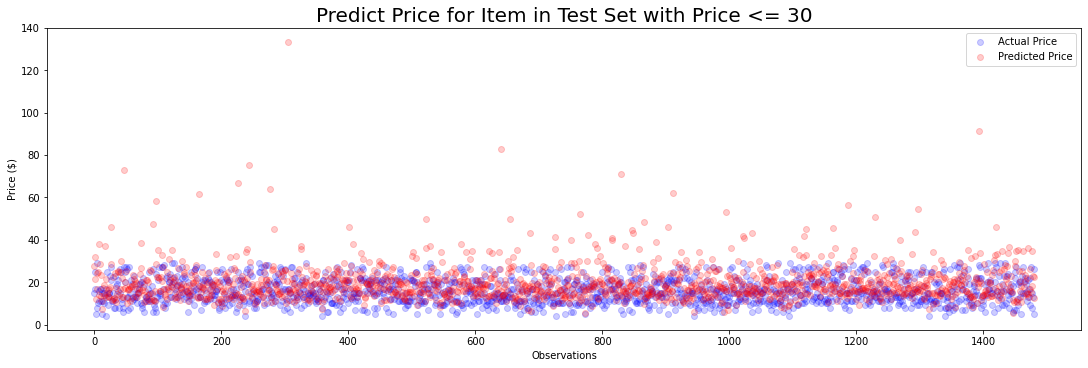

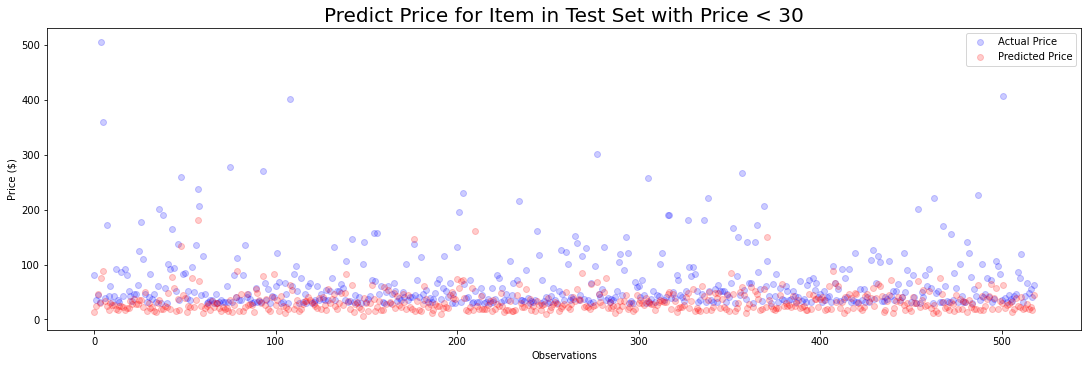

In [21]:
find_train_best_model(classifier, parameters, x_skb_select_train, y_train, 
                      x_skb_select_test, y_test, data_name="Feature from select k best model", price_split=30)

### Train with All features

In [ ]:
classifier = Ridge()
parameters = {'alpha': [1, 2, 3, 3.5, 4, 4.5, 5]}

In [ ]:
find_train_best_model(classifier, parameters, all_train, y_train, 
                      all_test, y_test, data_name="Feature from all data", price_split=30)

## DecisionTreeRegressor

### Train with select k best features

In [ ]:
classifier = DecisionTreeRegressor()
parameters = {'criterion': ['mse','poisson'], 'max_features': [50, 100, 500]}

In [ ]:
find_train_best_model(classifier, parameters, x_skb_select_train, y_train, 
                      x_skb_select_test, y_test, data_name="Feature from select k best model", price_split=30)

### Train with All features

In [ ]:
classifier = DecisionTreeRegressor()
parameters = {'criterion': ['mse','poisson'], 'max_features': [50, 100, 500, 1000, 2000, 4000]}

In [ ]:
find_train_best_model(classifier, parameters, all_train, y_train, 
                      all_test, y_test, data_name="Feature from all data", price_split=30)

## RandomForestRegressor

### Train with select k best features

In [ ]:
classifier = RandomForestRegressor()
parameters = {'n_estimators': [10, 50, 100, 500], 'max_features': [50, 100, 500]}

In [ ]:
find_train_best_model(classifier, parameters, x_skb_select_train, y_train, 
                      x_skb_select_test, y_test, data_name="Feature from select k best model", price_split=30)

### Train with All features

In [ ]:
classifier = RandomForestRegressor()
parameters = {'n_estimators': [10, 50, 100, 500], 'max_features': [50, 100, 500, 1000, 2000, 4000]}

In [ ]:
find_train_best_model(classifier, parameters, all_train, y_train, 
                      all_test, y_test, data_name="Feature from all data", price_split=30)